# About the data

---
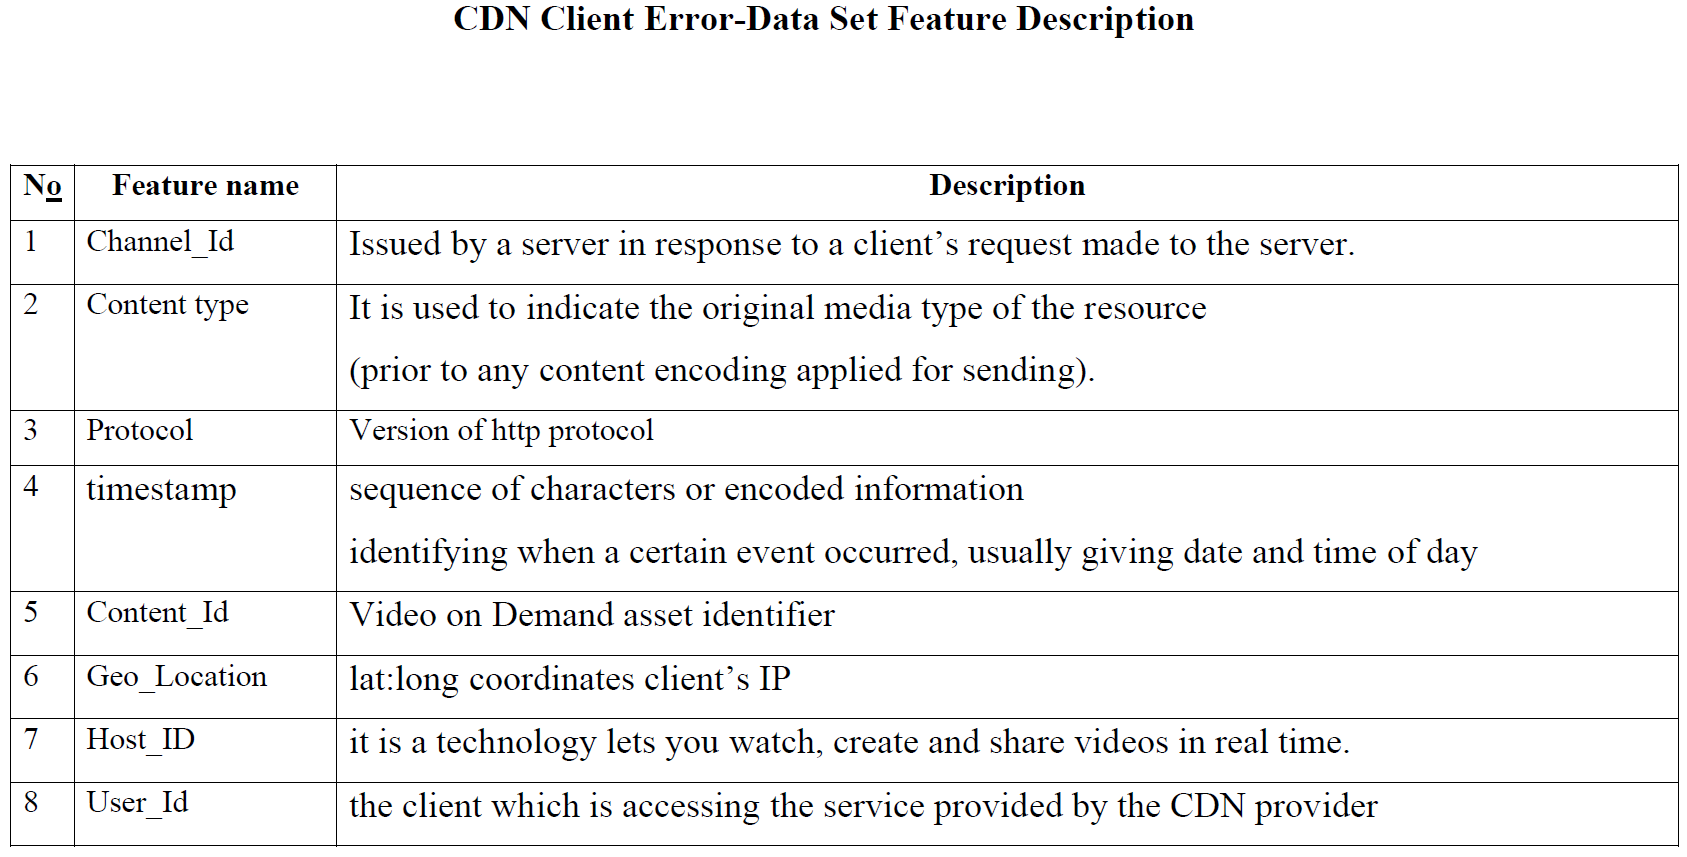

# Import Libraries

We first import the libraries that we will use in the notebook.

In [1]:
import pandas as pd # For dataframe manipulation
import numpy as np # For arrays and matrices manipulation
import networkx as nx # For graph manipulation

# For machine leaning pre processing and modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics

# For plotting charts and diagrams
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# For general use
from random import *

# Data Preprocessing

Before clustering our dataset, we will pre-process it to understand the data, make it suitable for the modelling and making sure that we are extracting the most information from it.

## Load data

We first import the dataset and create the pandas dataframe.



In [2]:
from google.colab import files
files.upload()
df = pd.read_csv("CDN Client Error.csv")

Saving CDN Client Error.csv to CDN Client Error.csv


## Data visualization

We plot pairwise relationships in the dataset to visualize potential clusters and point anomalies.

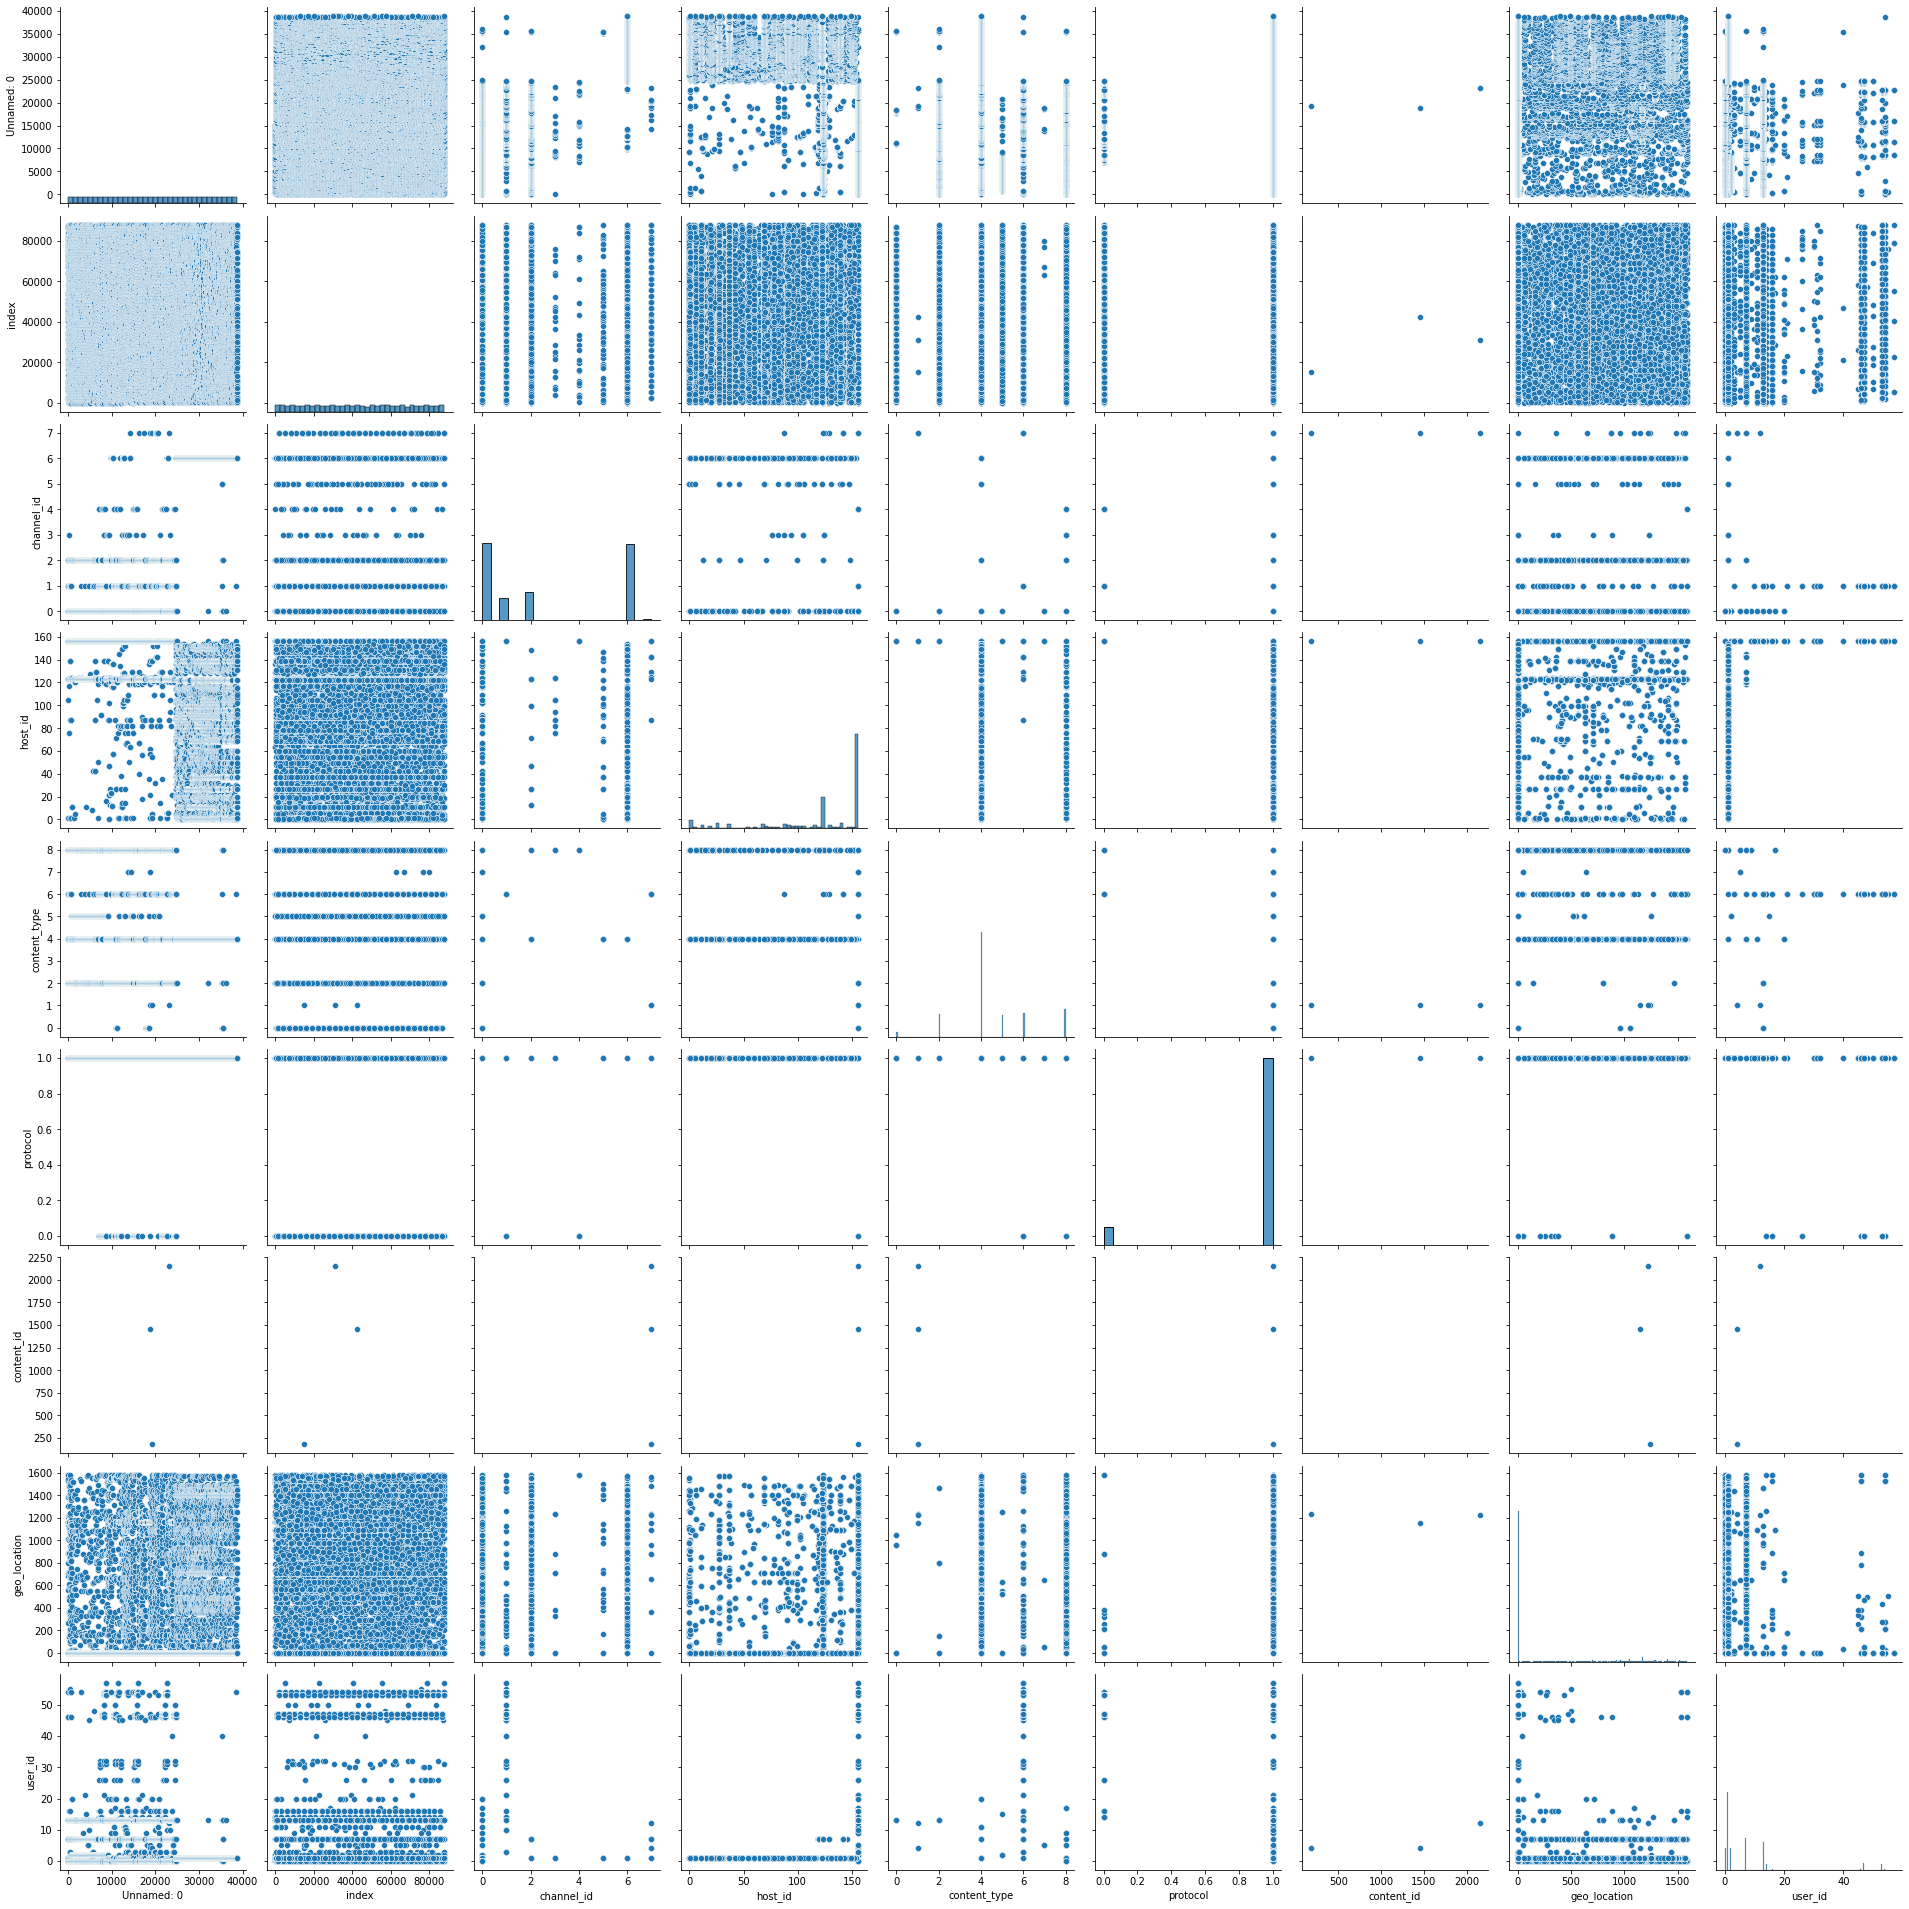

In [11]:
sns.pairplot(df, height=3, diag_kind="hist")

# K-means

K means does not support null values so we will start by dropping content_id column and filling the other null values with the average of the column (so it shouldn't have major influences on the clustering results).

In [17]:
df_kmeans = df.drop(columns=['timestamp', 'content_id']).fillna(df.drop(columns=['timestamp', 'content_id']).mean())



## Silhouette and Elbow analysis

In the following section we will analyze the optimal number of cluster to compute with K-Means algorithm. To achieve this we will use two different techniques, the **Silhouette** and **Elbow** analysis.

For 2 clusters the average silhouette_score is : 0.8396317866822502
For 3 clusters the average silhouette_score is : 0.8149479657039452
For 4 clusters the average silhouette_score is : 0.7668743882738293
For 5 clusters the average silhouette_score is : 0.7675896344071416
For 6 clusters the average silhouette_score is : 0.6897556655677956
For 7 clusters the average silhouette_score is : 0.691484595680781
For 8 clusters the average silhouette_score is : 0.6899651021282864


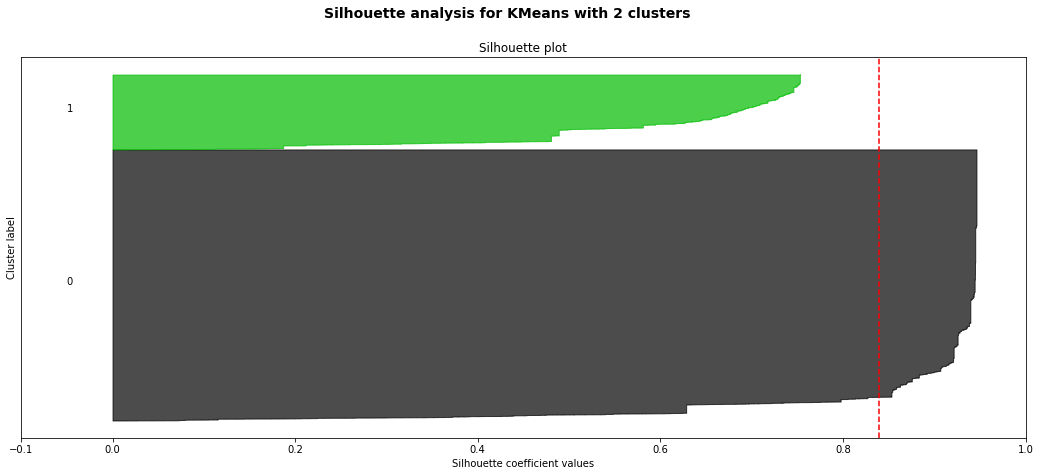

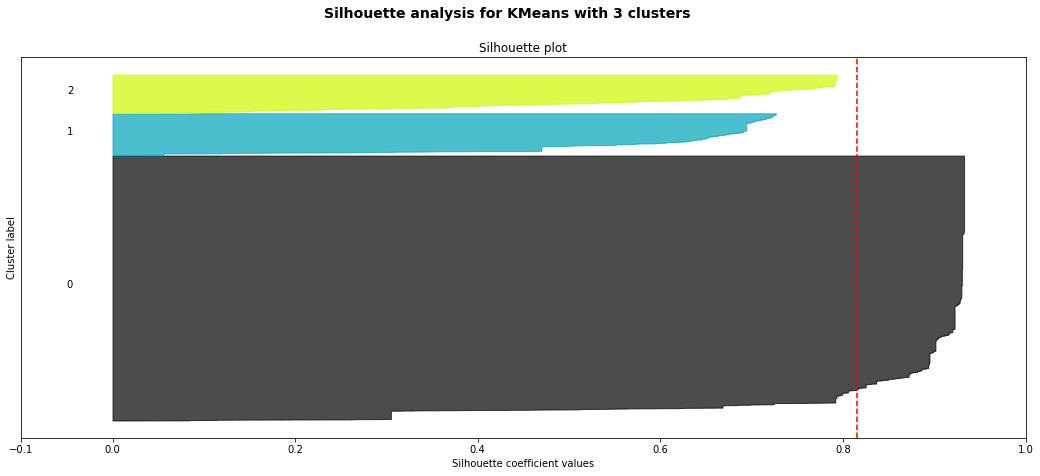

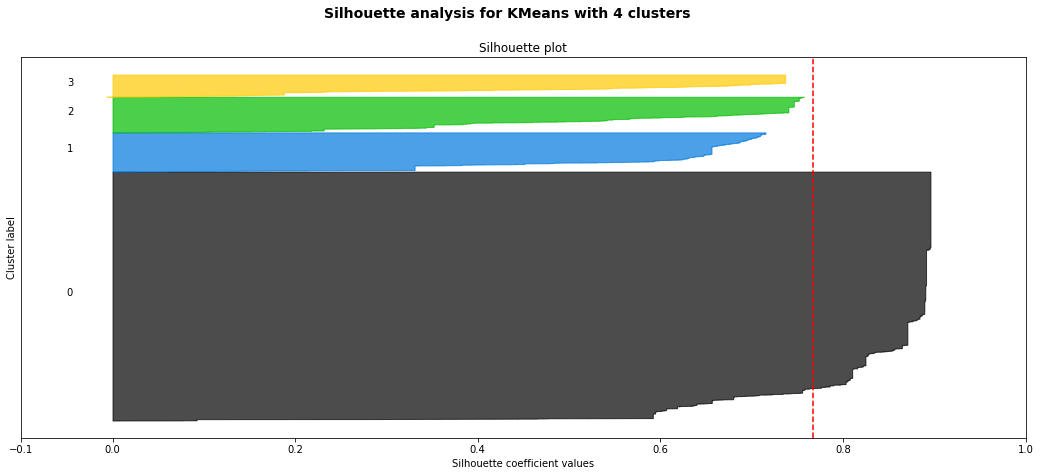

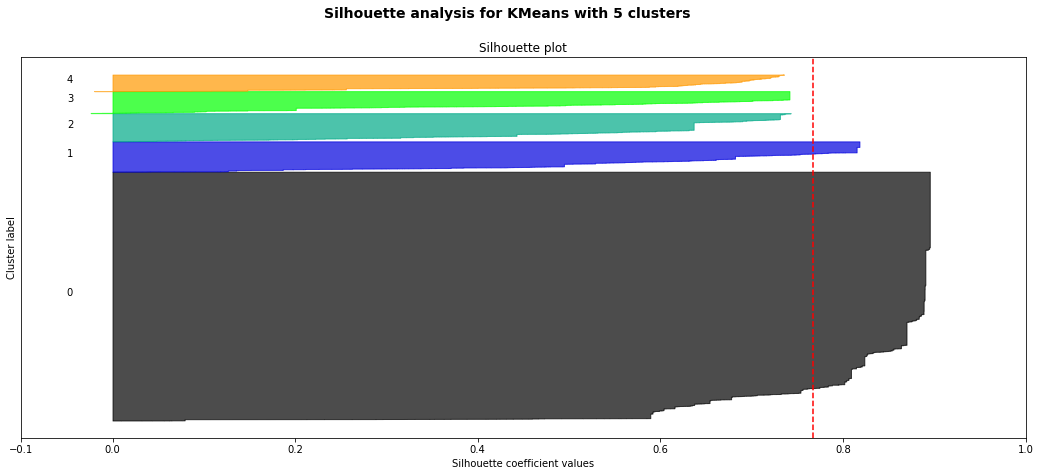

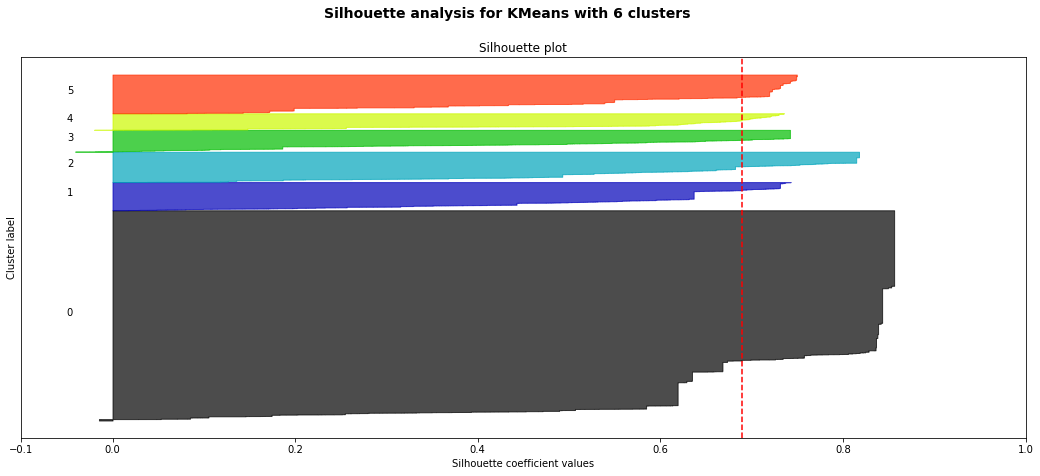

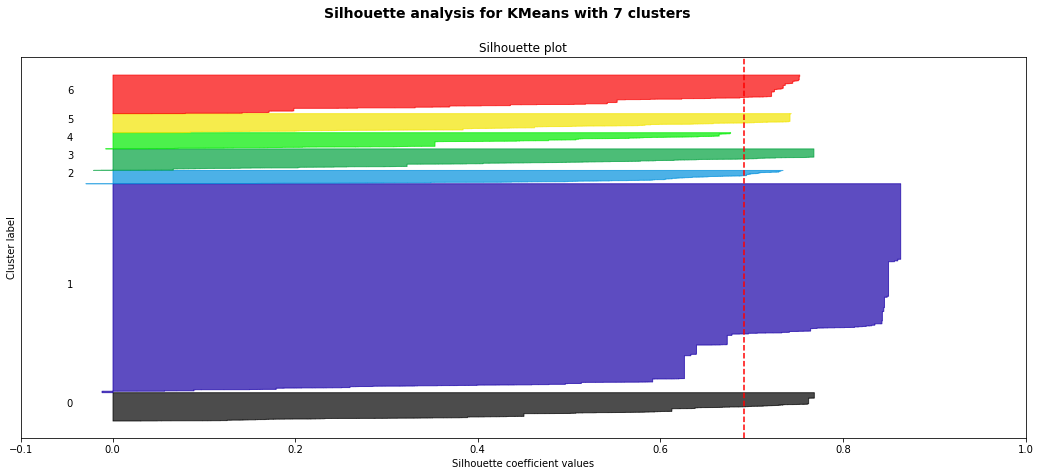

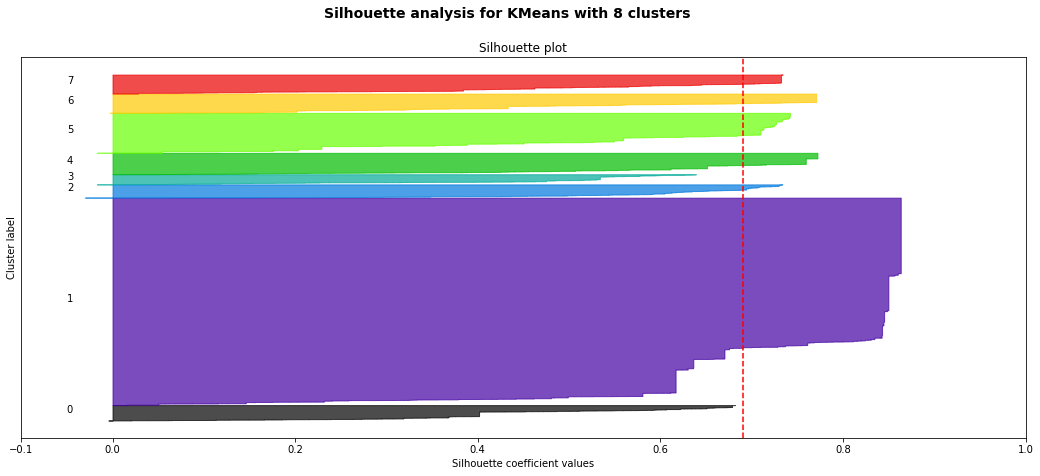

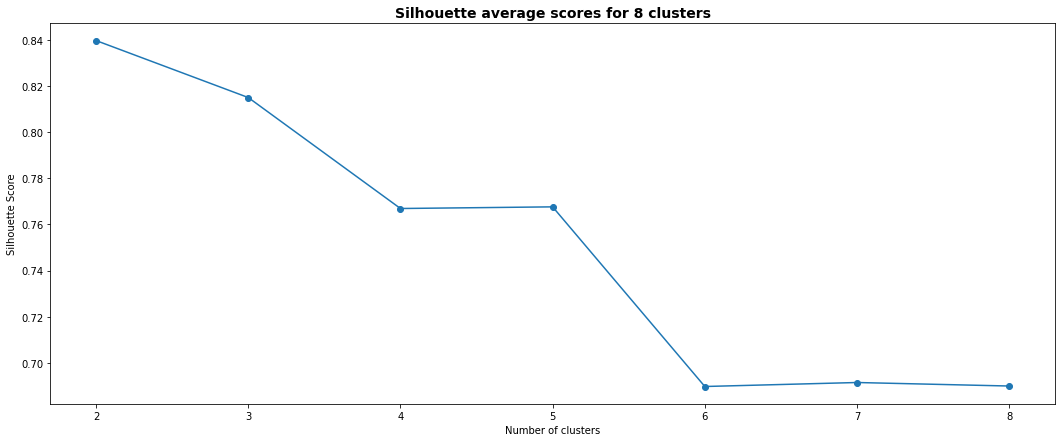

In [20]:
num_clusters = range(2,9) # we will analyse n_clusters from 2 to 9
silhouette_scores = []
SSE = []

for n_clusters in num_clusters:

    # Create a subplot
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # Initializing the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    kmeans.fit(df_kmeans)

    labels_pred = kmeans.predict(df_kmeans)

    #Computing the average silhouette_score
    sil_avg_score = metrics.silhouette_score(df_kmeans, labels_pred)
    print("For",n_clusters, "clusters",
          "the average silhouette_score is :", sil_avg_score)

    # Computing the silhouette scores for each sample
    sil_samples_score = metrics.silhouette_samples(df_kmeans, labels_pred)

    silhouette_scores.append(sil_avg_score)

    #Computing k means inertia for elbow analysis
    SSE.append(kmeans.inertia_)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        sil_values = \
            sil_samples_score[labels_pred == i]
        sil_values.sort()

        size_cluster = sil_values.shape[0]
        y_upper = y_lower + size_cluster

        color = cm.nipy_spectral(float(i) / n_clusters)
        a.fill_betweenx(np.arange(y_lower, y_upper),
                          0, sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Adding cluster number label
        a.text(-0.05, y_lower + 0.5 * size_cluster, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting low plot limit to -0.1 since the aren't silhouettes from -0.1
    a.set_xlim([-0.1, 1])
    a.set_title("Silhouette plot")
    a.set_xlabel("Silhouette coefficient values")
    a.set_ylabel("Cluster label")

    # Adding line of average silhouette score
    a.axvline(x=sil_avg_score, color="red", linestyle="--")
    a.set_yticks([])  # Clear the yaxis labels / ticks
    a.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(('Silhouette analysis for KMeans with ' + str(n_clusters) + ' clusters'),
                 fontsize=14, fontweight='bold')

plt.show()

# Plot of silhouette average score values
fig, a = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.title('Silhouette average scores for ' + str(n_clusters) + ' clusters', fontsize=14, fontweight='bold')
a.set_xlabel('Number of clusters')
a.set_ylabel('Silhouette Score')

plt.show()

We have plotted 2 different sort of figures to analyze the silhouette results.

Firstly we can observe silhouttes for different number of clusters, where the values of the silhouette ranges from -1 to +1. A value +1 indicates that the sample is far away from the neighboring clusters, 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

Secondly we plotted the average silhouette value for each number of clusters.

Observing the outputs it can be seen that the silhouettes with higher average values are the ones corresponding to 2 and 3 clusters numbers. 4 and 5 could also be acceptable choices but definitely not more than 5.

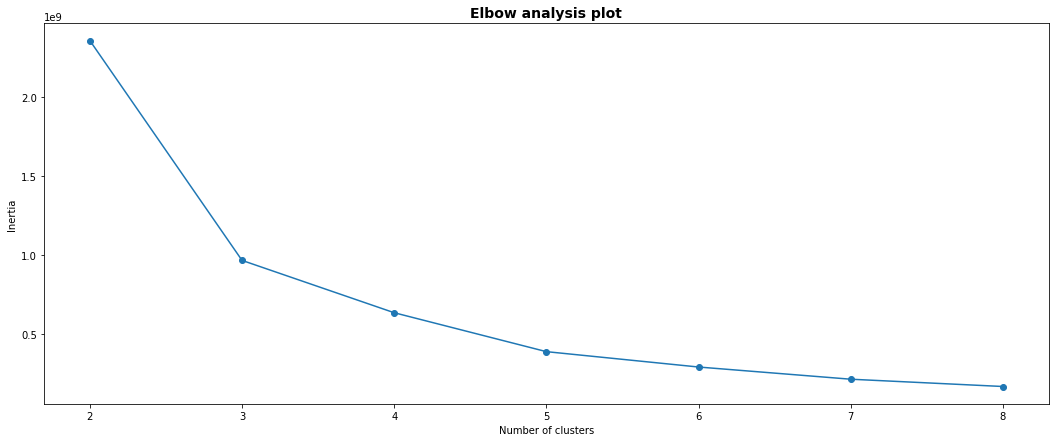

In [21]:
fig, a = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
plt.plot(num_clusters, SSE, marker='o')
plt.title('Elbow analysis plot', fontsize=14, fontweight='bold')
a.set_xlabel('Number of clusters')
a.set_ylabel('Inertia')
plt.show()

The elbow analysis plot shows the inertia of the K-Means for different number of clusters. The inertia is defined as the sum of squared distances of samples to their closest cluster center, i.e. SSE.

It can be seen that the output of the elbow analysis plot indicates that the optimal number of clusters is K=3. 

Comparing both analysis results we choose to run K-mean algorithm and to plot some visualizations for K=2, K=3 and K=4.

## Visualization of K-means algorithm

### Using K=2

We first run k-means again and get the predicted labels.

In [139]:
kmeans = KMeans(n_clusters=2, random_state=100)
labels_pred = kmeans.fit_predict(df_kmeans)

We will plot the samples in a three dimensional space, considering three features from our dataset (channel, geolocation and host id) so we can visualize the predicted clusters.

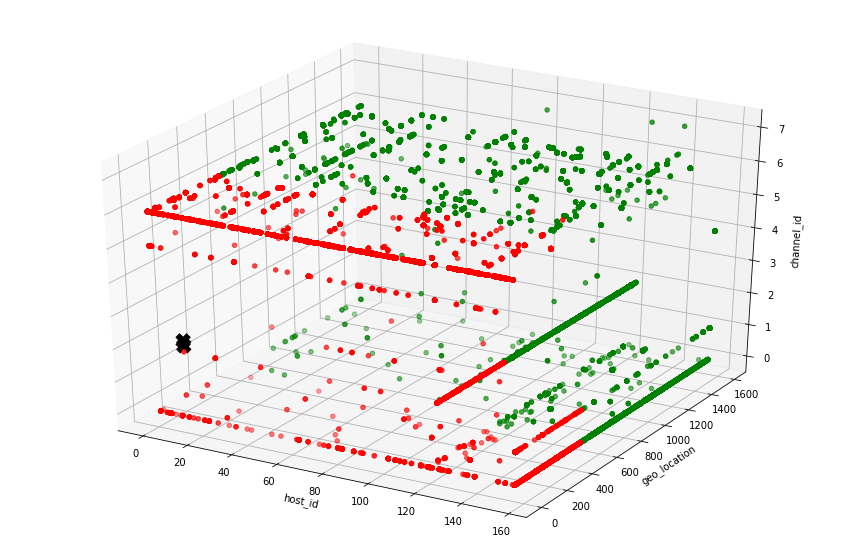

In [140]:
filtered_label0 = df_kmeans[labels_pred == 0]
filtered_label1 = df_kmeans[labels_pred == 1]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["host_id"], filtered_label0["geo_location"], filtered_label0["channel_id"],color="red")
ax.scatter(filtered_label1["host_id"], filtered_label1["geo_location"], filtered_label1["channel_id"],color="green")

ax.set_xlabel('host_id')
ax.set_ylabel('geo_location')
ax.set_zlabel('channel_id')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 1], centers[:,0], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')

### Using K=3

In [137]:
kmeans = KMeans(n_clusters=3, random_state=100)
labels_pred = kmeans.fit_predict(df_kmeans)

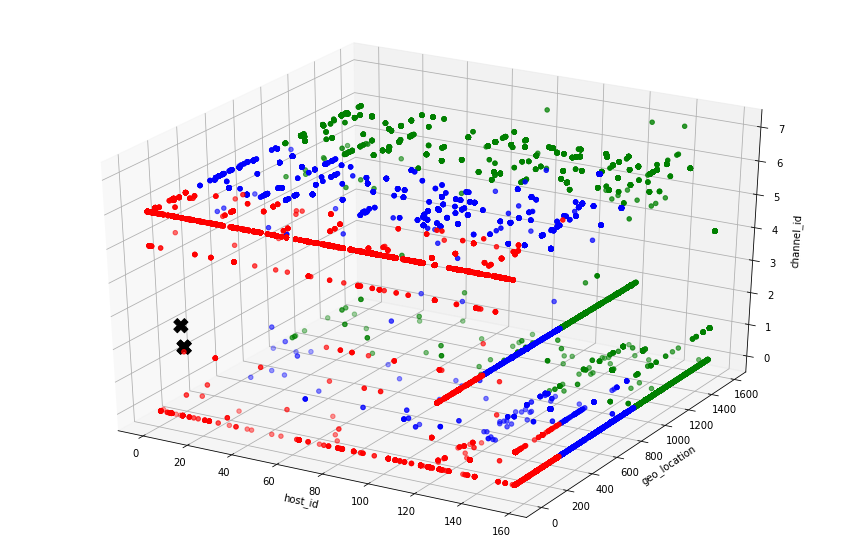

In [138]:
filtered_label0 = df_kmeans[labels_pred == 0]
filtered_label1 = df_kmeans[labels_pred == 1]
filtered_label2 = df_kmeans[labels_pred == 2]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["host_id"], filtered_label0["geo_location"], filtered_label0["channel_id"],color="red")
ax.scatter(filtered_label1["host_id"], filtered_label1["geo_location"], filtered_label1["channel_id"],color="green")
ax.scatter(filtered_label2["host_id"], filtered_label2["geo_location"], filtered_label2["channel_id"],color="blue")

ax.set_xlabel('host_id')
ax.set_ylabel('geo_location')
ax.set_zlabel('channel_id')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 1], centers[:,0], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')

### Using K=4

In [124]:
kmeans = KMeans(n_clusters=4, random_state=100)
labels_pred = kmeans.fit_predict(df_kmeans)

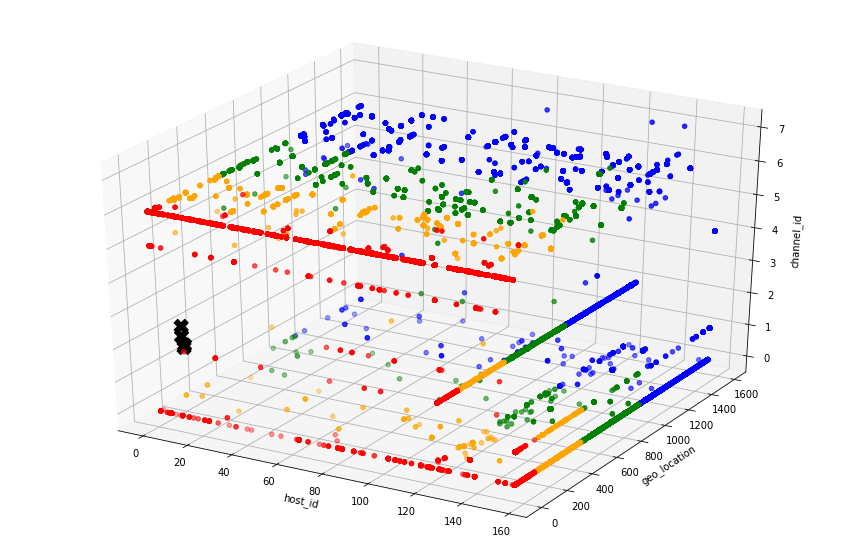

In [125]:
filtered_label0 = df_kmeans[labels_pred == 0]
filtered_label1 = df_kmeans[labels_pred == 1]
filtered_label2 = df_kmeans[labels_pred == 2]
filtered_label3 = df_kmeans[labels_pred == 3]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["host_id"], filtered_label0["geo_location"], filtered_label0["channel_id"],color="red")
ax.scatter(filtered_label1["host_id"], filtered_label1["geo_location"], filtered_label1["channel_id"],color="green")
ax.scatter(filtered_label2["host_id"], filtered_label2["geo_location"], filtered_label2["channel_id"],color="blue")
ax.scatter(filtered_label3["host_id"], filtered_label3["geo_location"], filtered_label3["channel_id"],color="orange")

ax.set_xlabel('host_id')
ax.set_ylabel('geo_location')
ax.set_zlabel('channel_id')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 2], centers[:, 1], centers[:,0], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')

# Spectral Clustering

To reduce the complexity of the next computations we only keep 1,000 rows randomly.

In [57]:
df_clustering = df_kmeans.sample(1000)

## Similarity

In this section we compute the pairwise distance and similarity for each pair of samples of the dataset. Afterwards this similarity is set as the weight of the edges between the nodes in the connectivity graph analysis. It is worth to highlight that we choose the euclidean distance and for the similarity we consider the Gaussian similarity function with the squared standard deviation of the distance as scaling factor since it is a common practice.

In [44]:
def get_distance(a, b):
  # Calculate the distance between a and b with the euclidean norm
  return np.linalg.norm(a-b)

def get_similarity(distance, std=1):
  # Calculate the similarity as the exponential of the square of the distance,
  # considering a scaling factor of std
  return np.exp(-np.square(distance)/(2*(std**2)))

We plot the frequency distribution of the distances so we know the range of values and can use this information to define the variables in the connectivity graphs.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


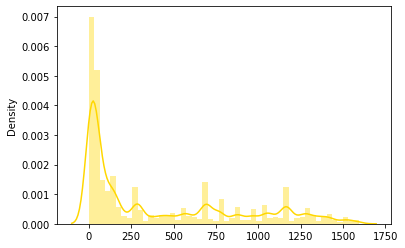

In [58]:
distances = []

# Loop through all combinations of rows of the dataset
for index, row in df_clustering.iterrows():
  for index_other, row_other in df_clustering.iterrows():
    if index < index_other: # ensures that each pair is analysed just once
      distance = get_distance(row.values, row_other.values)
      distances.append(distance)

sns.distplot(distances, hist=True, color='gold')
distance_std = np.std(distances, axis=0)

We also plot the frequency distribution of the similarities, where the high distances are mapped to 0 and the small distances are mapped to values close to one.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


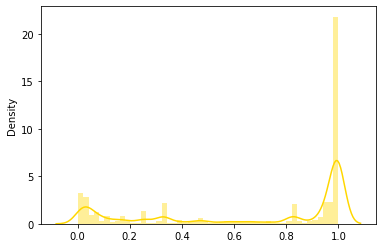

In [59]:
similarities = []

# Loop through all combinations of rows of the dataset
for index, row in df_clustering.iterrows():
  for index_other, row_other in df_clustering.iterrows():
    if index < index_other: # ensures that each pair is analysed just once
      distance = get_distance(row.values, row_other.values)
      similarity = get_similarity(distance, std=distance_std)
      similarities.append(similarity)

sns.distplot(similarities, hist=True, color='gold')

## Connectivity Graph

In this section we will define four kind of similarity graphs that we test for the dataset. In the similarity graphs, the nodes are equivalente to a sample of the dataset (a row) and the edges express the similarity between them.



*   **Completely connected graph (CCG):** In this graph every pair of nodes are connected by an edge with weight equal to the similarity between the two nodes.

* **Epsilon-neighborhood graph (ENG):**
 In this graph a two vertices are connected by an edge if their distance is less than a parameter epsilon. We also choose to set the weight of the edges as the similarity between the connected nodes for this graph.

* **Symmetric k-nearest neighbor graph (SKNG):** In this graph two vertices are connected if one is among the k-nearest neighbors of the other or vice versa.

* **Mutual k-nearest neighbor graph (MKNG):** In this graph two vertices are connected if one is among the k-nearest neighbors of the other **and** vice versa.

In [62]:
def build_completly_connected_graph(dataset, distance_std):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    for index_other, row_other in dataset.iterrows():
      if index < index_other: # ensures that each pair is analysed just once
        distance = get_distance(row.values, row_other.values)
        similarity = get_similarity(distance, std=distance_std)
        graph.add_edge(index, index_other, weight=similarity) # add edge to graph
  return graph

def build_epsilon_neighborhood_graph(dataset, distance_std, epsilon=0.8):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    for index_other, row_other in dataset.iterrows():
      if index < index_other: # ensures that each pair is analysed just once
        distance = get_distance(row.values, row_other.values)
        similarity = get_similarity(distance, std=distance_std)
        if distance < epsilon:
          graph.add_edge(index, index_other, weight=similarity) # add edge to graph
  return graph

def build_symmetric_k_nearest_neighbor_graph(dataset, distance_std, k=15):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Create a nearest neighbor model and fit to the data
  knn = NearestNeighbors(n_neighbors=(k+1))
  knn.fit(dataset)

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    # Get the k nearest neighbors from the current row and its euclidean distance
    distances, neighbors = knn.kneighbors(row.values.reshape(1, -1), return_distance=True)
    for i_neighbor in range(1, k + 1): # loop through current row's nearest neighbors
      similarity = get_similarity(distances[0, i_neighbor], std=distance_std)
      graph.add_edge(index, neighbors[0, i_neighbor], weight=similarity) # add edge to graph
  return graph

def build_mutual_k_nearest_neighbor_graph(dataset, distance_std, k=15):
  # Create an empty undirected graph
  graph = nx.Graph()

  # Create a nearest neighbor model and fit to the data
  knn = NearestNeighbors(n_neighbors=(k+1))
  knn.fit(dataset)

  # Create a dictionary to hold the nearest neighbors of the previous rows
  nearest_neighbors = {}

  # Loop through all combinations of rows of the dataset
  for index, row in dataset.iterrows():
    graph.add_node(index)
    # Get the k nearest neighbors from the current row and its euclidean distance
    distances, neighbors = knn.kneighbors(row.values.reshape(1, -1), return_distance=True)
    nearest_neighbors[index] = neighbors[0] # add nearest neighbors to the history
    for i_neighbor in range(1, k + 1): # loop through current row's nearest neighbors
      # If the knn of the neighbor has already been calculated
      if neighbors[0, i_neighbor] in nearest_neighbors:
        # If the current row was also a nearest neighbor of the neighbor
        if index in nearest_neighbors[neighbors[0, i_neighbor]]:
          # Calculate similarity and add edge to graph
          similarity = get_similarity(distances[0, i_neighbor], std=distance_std)
          graph.add_edge(index, neighbors[0, i_neighbor], weight=similarity)
  return graph

We also define a function to plot the graphs in a way the helps with visualization and choice of the parameters.

We plot the graph in a layout where the nodes connected with an edge with higher weight are closer than the nodes connected by edges with lower weight. We color the nodes of the graph according to the connected component it belongs to.

In [63]:
def plot_graph(graph):
  colorlist = ['gold', 'darkorange', 'forestgreen', 'teal', 'navy', 'indianred', 'blueviolet', 'darkgreen', 'firebrick', 'olive']
  pos = nx.spring_layout(graph)
  connected_components = nx.connected_components(graph)

  for index, cc_nodes in enumerate(connected_components):
    subgraph = graph.subgraph(nodes=cc_nodes)
    if index > 9:
      color = 'black'
    else:
      color = colorlist[index]
    nx.draw(subgraph, pos=pos, edge_color='grey', node_color=color, node_size=10)

We will now plot an example of each similarity graph. The choice of the parameters (k-nearest-neighbors and epsilon) was done by trial an error observing the impact of the parameters in the graph visualization (connected components). The parameters ploted below are the ones that we have considered the best for the combination of final features selected.

### Plotting Completely Connected Graph

The number of edges of the graph is 499500 with 1000 nodes


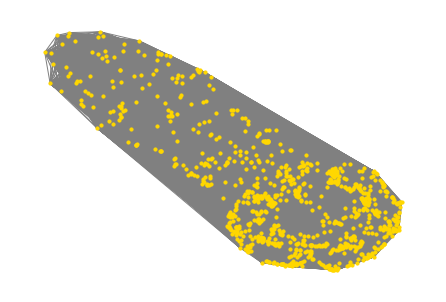

In [64]:
g = build_completly_connected_graph(df_clustering, distance_std)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
nx.draw(g, node_color='gold', pos=nx.spring_layout(g), edge_color='grey', node_size=10)

### Plotting Epsilon-neighborhood Graph



The number of edges of the graph is 35550 with 1000 nodes


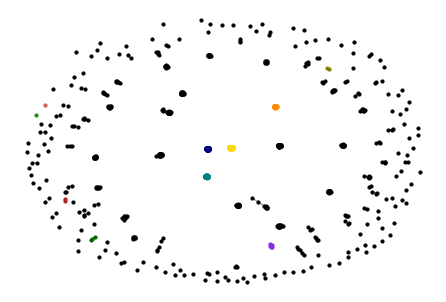

In [65]:
g = build_epsilon_neighborhood_graph(df_clustering, distance_std, epsilon=1.01)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

### Plotting Symmetric K-nearest Neighbor Graph

The number of edges of the graph is 5000 with 1452 nodes


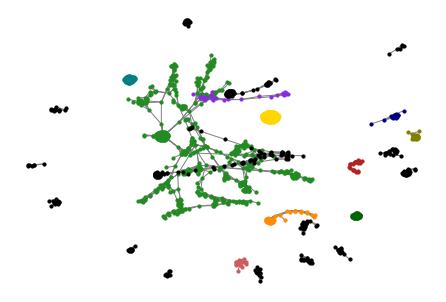

In [122]:
g = build_symmetric_k_nearest_neighbor_graph(df_clustering, distance_std, k=5)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

### Plotting Mutual K-nearest Neighbor Graph

The number of edges of the graph is 0 with 1000 nodes


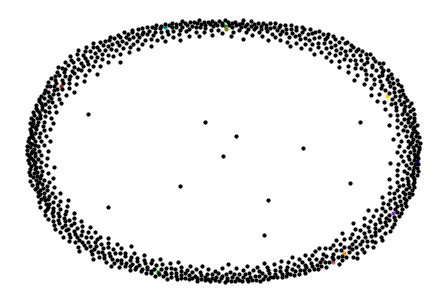

In [136]:
g = build_mutual_k_nearest_neighbor_graph(df_clustering, distance_std)
print('The number of edges of the graph is %d with %d nodes'%(g.number_of_edges(), g.number_of_nodes()))
plot_graph(g)

## Clustering Operation

In [68]:
def get_normalized_laplacian_matrix(graph):
  # Get the laplacian matrix
  L = nx.laplacian_matrix(graph)
  L = L.todense() # convert it from sparse to dense numpy matrix

  # Build the degree matrix
  d = np.diagonal(L) # get the diagonal from the laplacian matrix
  D = np.diag(d) # build a diagonal matrix with the diagonal of the laplacian
  
  # Calculate the normalized laplacian matrix
  Ld = np.linalg.pinv(D)*L
  # Ld = np.linalg.sqrtm(D)*L*np.linalg.sqrtm(D)

  return Ld

In [69]:
def get_sorted_eig(matrix):
  # Calculate the eigenvalues and eigenvectors of the matrix
  lbda, V = np.linalg.eig(matrix)

  # Sort the eigenvalues and eigenvectors from the smallest eigenvalue to the biggest
  sorted_index = np.argsort(lbda)
  sorted_lbda = lbda[sorted_index]
  sorted_V = V[:,sorted_index]

  return sorted_lbda, sorted_V

In [70]:
def plot_eigengap(sorted_lbda):
  plt.figure()
  plt.title("Eigenvalues")
  plt.xlabel("Eigenvalue Position")
  plt.ylabel("Eigenvalue")
  plt.scatter(np.arange(len(sorted_lbda)), sorted_lbda)

  plt.figure()
  plt.title("Eigenvalues")
  plt.xlabel("Eigenvalue Position")
  plt.ylabel("Eigenvalue")
  plt.scatter(np.arange(2, 10), sorted_lbda[1:9])

## Clustering

In this section we compute the spectral clustering with the completely connected graph. 

To make decision of wich cut criteria we should choose we considered the following two aspects:

*   We want to find a partition such that points in different clusters are dissimilar to each other, that is we want to minimize the between-cluster similarity.

*   We want to find a partition such that points in the same cluster are similar to each other, that is we want to maximize the within-cluster similarities.

Both *Normalized-cut* and *Ratio-cut* criteria successfully fullfill the first point, however only *Normalized-cut* fulfills the seconds point, which in the end produces more balanced partitions.

Therefore, we decided to use the *Normalized-cut* criterion and for that reason we ended up using the Normalized Laplacian matrix.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


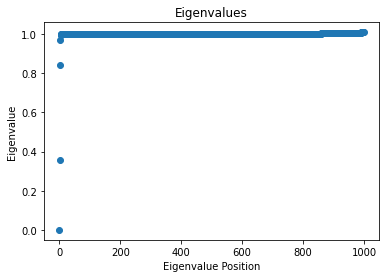

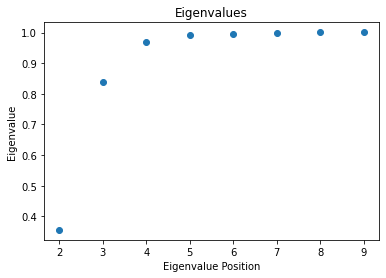

In [97]:
G = build_completly_connected_graph(df_clustering, distance_std)
Ld = get_normalized_laplacian_matrix(G)
lbda, V = get_sorted_eig(Ld)
plot_eigengap(lbda)

As we can see in the previous figures the biggest "eigen gap" is in between the second and third eigen value. This suggests that the optimal number of clusters should be K=2

In [98]:
#Computing the exact distance
print("Distance between second and third eigen value: ", lbda[2]-lbda[1])
print("Distance between third and fourth eigen value: ", lbda[3]-lbda[2])

Distance between second and third eigen value:  (0.4840824660886611+0j)
Distance between third and fourth eigen value:  (0.12992100046551036+0j)


### Eigenvectors analysis

Let's take a look at first 3 corresponding eigenvectors. 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


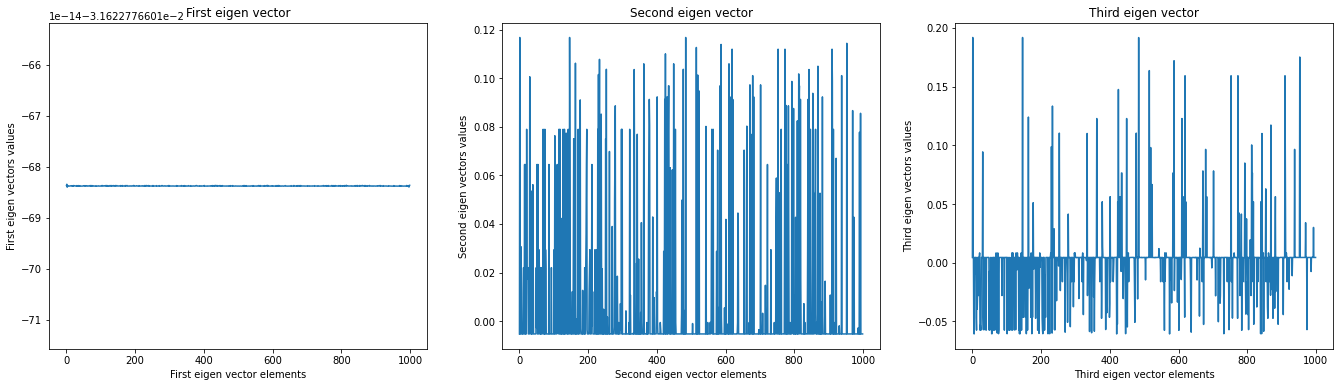

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(23, 6)
ax1.plot(V[:,0])
ax2.plot(V[:,1])
ax3.plot(V[:,2])
ax1.set_title('First eigen vector')
ax1.set_xlabel('First eigen vector elements')
ax1.set_ylabel('First eigen vectors values')
ax2.set_title('Second eigen vector')
ax2.set_xlabel('Second eigen vector elements')
ax2.set_ylabel('Second eigen vectors values')
ax3.set_title('Third eigen vector')
ax3.set_xlabel('Third eigen vector elements')
ax3.set_ylabel('Third eigen vectors values')
plt.show()

### Visualization

#### Using K=2

In [110]:
k = 2
V_cluster = V.real[:, :k]
V_df = pd.DataFrame(V_cluster)
kmeans = KMeans(n_clusters=k, random_state=10)
cluster_labels = kmeans.fit_predict(V_df)

After the execution of K-Means on the 3 first eigen vectors we can plot the second and third vectors along the predicted labels.

*Note: The first eigen vector is a constant value since we are using completely connected graph. This means that there is only one component, which makes sense according to the multiplicity of the eigenvalue zero (there is only one eigenvalue corresponding to zero, the first eigen value).*

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


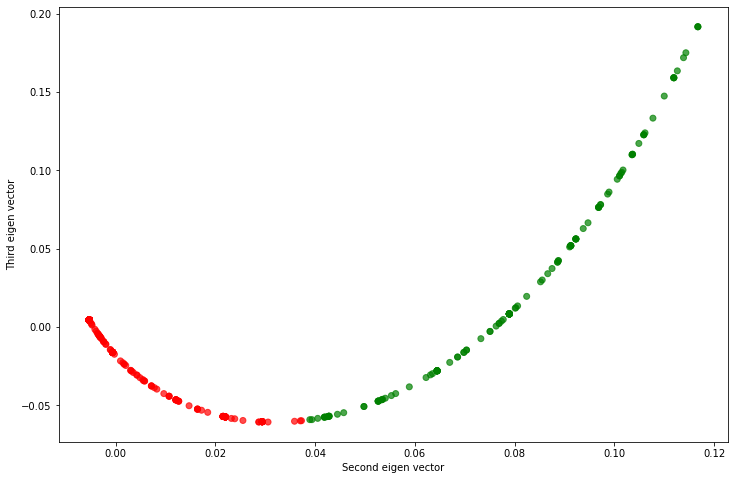

In [113]:
LABEL_COLOR_MAP = {0:'r', 1:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in cluster_labels]

fig, ax= plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.scatter([V[:,1]],[V[:,2]], c=label_color, alpha=0.7)
ax.set_xlabel('Second eigen vector')
ax.set_ylabel('Third eigen vector')

plt.show()

#### Using K=3

In [115]:
k = 3
V_cluster = V.real[:, :k]
V_df = pd.DataFrame(V_cluster)
kmeans = KMeans(n_clusters=k, random_state=10)
cluster_labels = kmeans.fit_predict(V_df)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


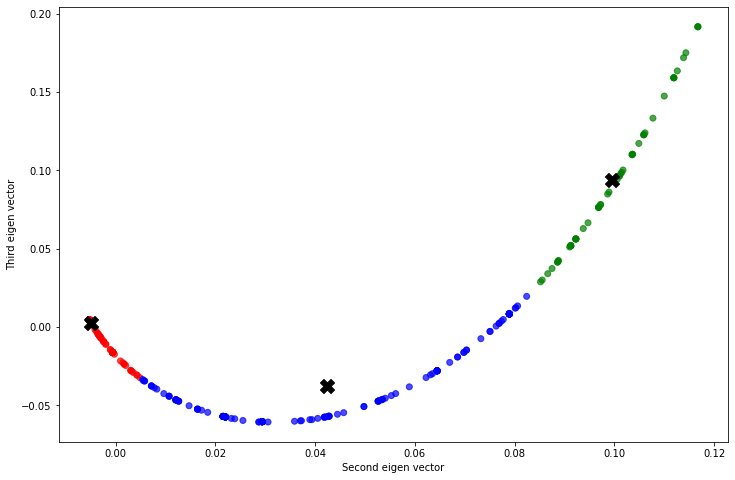

In [107]:
LABEL_COLOR_MAP = {0:'r', 1:'g', 2:'b'}
label_color = [LABEL_COLOR_MAP[l] for l in cluster_labels]

fig, ax= plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.scatter([V[:,1]],[V[:,2]], c=label_color, alpha=0.7)
ax.set_xlabel('Second eigen vector')
ax.set_ylabel('Third eigen vector')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 1], centers[:, 2], marker='X',
                c="black", alpha=1, s=200, edgecolor='k')
plt.show()

## Visualization

Lastly, we will plot the samples in a three dimensional space so we can visualize the predicted clusters.

Text(0.5, 0, 'channel_id')

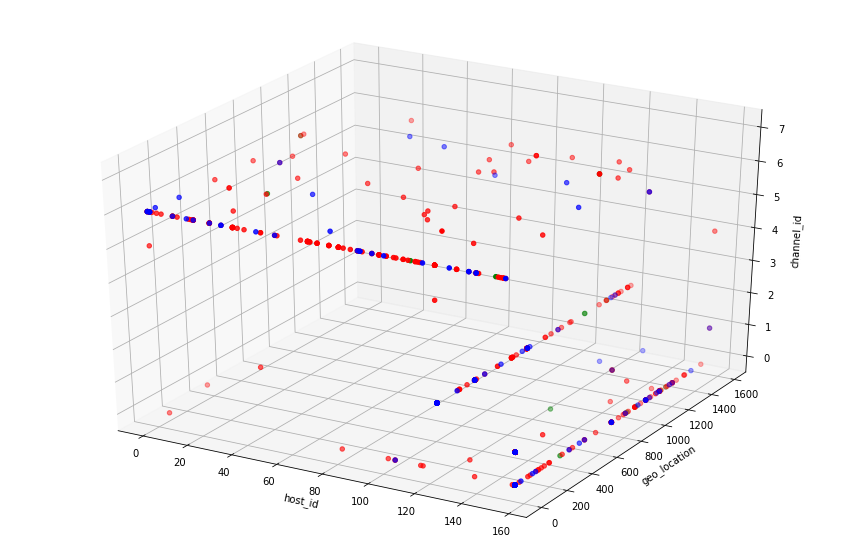

In [120]:
filtered_label0 = df_clustering[cluster_labels == 0]
filtered_label1 = df_clustering[cluster_labels == 1]
filtered_label2 = df_clustering[cluster_labels == 2]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection="3d")

ax.scatter(filtered_label0["host_id"], filtered_label0["geo_location"], filtered_label0["channel_id"],color="red")
ax.scatter(filtered_label1["host_id"], filtered_label1["geo_location"], filtered_label1["channel_id"],color="green")
ax.scatter(filtered_label2["host_id"], filtered_label2["geo_location"], filtered_label2["channel_id"],color="blue")

ax.set_xlabel('host_id')
ax.set_ylabel('geo_location')
ax.set_zlabel('channel_id')